<div class="infotext" style='padding:0.1em; color:#000000'>
<span>
<p style='margin-top:1em; text-align:center'><font size="10"><b>Spanish-to-Tarahumara Translation</b></font></p>
    <p style='margin-top:1em; text-align:center'><font size="5"><b>Bidirectional LSTM Encoder - Bidirectional LSTM Decoder with Attention Layer</b></font></p>
</span>
</div>

In [1]:
# Spanish-Tarahumara-Translator:  Bidirectional LSTM Encoder - Bidirectional LSTM Decoder with Attention Layer
# Copyright (C) 2022  Eduardo Aguilar Moreno

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Import Modules

In [2]:
import os
import time
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
%matplotlib inline

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#!nvidia-smi

# Viewing Sentence Lengths

In [5]:
FILE_NAME = "./corpora/rarámuri.txt"
#FILE_NAME = "./corpora/americasnlp2021.txt"
#FILE_NAME = "/content/drive/MyDrive/Spanish-Tarahumara-Translator/corpora/rarámuri.txt"
#FILE_NAME = "/content/drive/MyDrive/Spanish-Tarahumara-Translator/corpora/americasnlp2021.txt"

CORPUS_NAME = FILE_NAME.split(sep='/')[-1].split(sep='.')[0]

with open(FILE_NAME, mode = 'rt', encoding = 'utf-8') as infile:
    lines = infile.read()
    sentences = lines.strip().split('\n')
    sentences = [item.split('|') for item in sentences]
    spa_tar = np.array(sentences, dtype=object)

# Extract Spanish and Tarahumara sentences from corpus
spa = spa_tar[:, 0]
tar = spa_tar[:, 1]

# Remove unnecessary whitespaces
spa = np.array([s.strip() for s in spa])
tar = np.array([s.strip() for s in tar])

# Remove punctuation and lowercase
spa = np.array([s.translate(str.maketrans('', '', string.punctuation + "¿¡")).lower() for s in spa])
tar = np.array([s.translate(str.maketrans('', '', string.punctuation.replace("'", "") + "¿¡")).lower() for s in tar])

# Viewing sentence lengths
spa_len = [len(s.split()) for s in spa]
tar_len = [len(s.split()) for s in tar]

print(f'Maximum length in Spanish: {max(spa_len)}')
print(f'Maximum length in Tarahumara: {max(tar_len)}')

length_df = pd.DataFrame({'Spanish':spa_len, 'Tarahumara':tar_len})

Maximum length in Spanish: 83
Maximum length in Tarahumara: 103


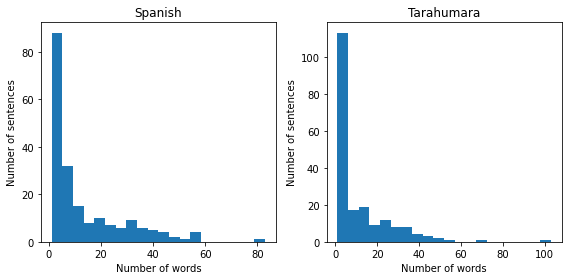

In [6]:
fig, ax = plt.subplots(1, 2, sharey = False, tight_layout = True, figsize = (8, 4))

# We can set the number of bins with the *bins* keyword argument.
ax[0].hist(length_df['Spanish'], bins = 20)
ax[0].set_title('Spanish')
ax[0].set_xlabel('Number of words')
ax[0].set_ylabel('Number of sentences')
ax[1].hist(length_df['Tarahumara'], bins = 20)
ax[1].set_title('Tarahumara')
ax[1].set_xlabel('Number of words')
ax[1].set_ylabel('Number of sentences')
#fig.suptitle('Sentence Lengths', fontsize=14)
fig.savefig('./images/sentence_lengths_' + CORPUS_NAME + '.png', format = 'png')
#fig.savefig('/content/drive/MyDrive/Spanish-Tarahumara-Translator/images/sentence_lengths_' + CORPUS_NAME + '.png', format = 'png')

# Data Preprocessing

In [7]:
class NMT_Parallel_Corpus:
    def __init__(self, filepath = None, problem_type = 'source-target'):
        self.filepath = filepath
        self.problem_type = problem_type
        self.encoder_tokenizer = None
        self.decoder_tokenizer = None
        self.selection_size = None
        self.total_size = None
        self.train_set = None
        self.validation_set = None
        
    def text_preprocessing(self, text):

        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        text = re.sub(r"([?.¡!,¿])", r" \1 ", text)
        text = re.sub(r'[" "]+', " ", text)

        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'") and Spanish special characters
        text = re.sub(r"[^a-zA-Z0-9?.¡!,¿áÁéÉíÍóÓúÚñÑüÜ']+", " ", text)

        text = text.lower()
        text = text.strip()

        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        text = "<SOS> " + text + " <EOS>"
        return text

    def load_data(self, num_examples):
        with open(self.filepath, mode = 'rt', encoding = 'utf-8') as infile:
            lines = infile.read()
            sentences = lines.strip().split('\n')
            sentences = [item.split('|') for item in sentences]
            
            self.total_size = len(sentences)
            
            if self.problem_type == 'source-target':
                source = [self.text_preprocessing(source) for source, target, _, _ in sentences[:num_examples]]
                target = [self.text_preprocessing(target) for source, target, _, _ in sentences[:num_examples]]
            
            elif self.problem_type == 'target-source':
                source = [self.text_preprocessing(source) for target, source, _, _ in sentences[:num_examples]]
                target = [self.text_preprocessing(target) for target, source, _, _ in sentences[:num_examples]]
                
            else:
                print('ERROR:  Unknown problem type!')
            
            self.selection_size = len(source)

            return source, target
    
    def tokenize(self, text, max_text_length):
        
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
        tokenizer.fit_on_texts(text)
        tokenizer.word_index['<PAD>'] = 0
        sequence_list = tokenizer.texts_to_sequences(text)
        
        if max_text_length == None:
            max_len = max([len(sequence) for sequence in sequence_list])
            
        else:
            max_len = max_text_length

        # Pad the sequences to match the longest sequences in the given input
        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequence_list, maxlen = max_len, padding = 'post')

        return padded_sequences, tokenizer
    
    def create_datasets(self, BATCH_SIZE, num_examples = None, max_length = None):
        if self.filepath == None:
            print('WARNING:  Sets cannot be created.  Variable pathfile not set!')
            return None, None, None, None
            
        else:
            input_lang, target_lang = self.load_data(num_examples)
            
            train_input, val_input, train_target, val_target = train_test_split(input_lang, target_lang, test_size = 0.1, random_state = 100)
            self.train_set = pd.DataFrame({'Source':train_input, 'Target':train_target})
            self.validation_set = pd.DataFrame({'Source':val_input, 'Target':val_target})
        
            encoder_sequences, self.encoder_tokenizer = self.tokenize(train_input, max_length)
            decoder_sequences, self.decoder_tokenizer = self.tokenize(train_target, max_length)
            
            # The buffer size must be equal or bigger than the total number of sentence pairs in the dataset
            BUFFER_SIZE = len(train_input)

            train_dataset = tf.data.Dataset.from_tensor_slices((encoder_sequences, decoder_sequences))
            train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)

            return train_dataset, self.encoder_tokenizer, self.decoder_tokenizer

# Hyperparameters

In [8]:
EPOCHS = 80
BATCH_SIZE = 16
EMBEDDING_DIM = 128
UNITS = 256
NUM_EXAMPLES = None # None -> consider the whole dataset
MAX_LENGTH = 20 # None -> consider the whole length

# Load Data

In [9]:
corpus = NMT_Parallel_Corpus(FILE_NAME)

In [10]:
train_dataset, tok_enc, tok_dec = corpus.create_datasets(BATCH_SIZE, NUM_EXAMPLES, MAX_LENGTH)

In [11]:
print(f'Total corpus size: {corpus.total_size}')
print(f'Selected corpus size: {corpus.selection_size}')

Total corpus size: 198
Selected corpus size: 198


In [12]:
# Get the word to index mapping for input language
word2idx_inputs = tok_enc.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# Get the word to index mapping for output language
word2idx_outputs = tok_dec.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# Map indexes back into real words so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 901 unique input tokens.
Found 780 unique output tokens.


In [13]:
input_vocab_size = len(tok_enc.word_index) + 1
target_vocab_size = len(tok_dec.word_index) + 1
max_length_input = list(train_dataset.as_numpy_iterator())[0][0].shape[1]
max_length_target = list(train_dataset.as_numpy_iterator())[0][1].shape[1]

# Model Architechture

## Bidirectional Encoder

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, input_vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_units = encoder_units
        
        # The Embedding layer convets token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, embedding_dim)

        # The LSTM layer processes those vectors sequentially
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.encoder_units,
                                                                       return_sequences = True,
                                                                       return_state = True,
                                                                       recurrent_initializer = 'glorot_uniform'))
    
    def call(self, tokens, hidden_state = None):
        
        # The Embedding layer looks up the embedding for each token
        embedding_vector = self.embedding(tokens)
        
        # None as default causes creation of zero-filled initial state tensors
        all_h, fwd_h, fwd_c, bwd_h, bwd_c = self.lstm(embedding_vector, initial_state = hidden_state)
        
        # Returns the new sequence and its state
        return all_h, fwd_h, fwd_c, bwd_h, bwd_c

## Attention Layer

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):

        w1_query = self.W1(query)
        w2_key = self.W2(value)
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(inputs = [w1_query, value, w2_key],
                                                           mask = [query_mask, value_mask],
                                                           return_attention_scores = True)

        return context_vector, attention_weights

## Bidirectional Decoder

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, target_vocab_size, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoder_units = decoder_units
    
        # The Embedding layer convets token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, embedding_dim)
        
        # The LSTM keeps track of what's been generated so far
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.decoder_units,
                                                  return_sequences=True,
                                                  return_state=True,
                                                  recurrent_initializer='glorot_uniform'))
        
        # The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.decoder_units*2)

        # Used to convert context vector to attention vector
        self.Wc = tf.keras.layers.Dense(self.decoder_units*2, 
                                        activation = tf.math.tanh,
                                        use_bias = False)
        
        # Final Dense layer on which softmax will be applied
        self.dense = tf.keras.layers.Dense(target_vocab_size)

    def call(self, tokens, encoder_output, mask, initial_state = None):
        
        # Lookup the embeddings
        embedding_vector = self.embedding(tokens)
        
        # Process one step with the LSTM
        all_h, fwd_h, fwd_c, bwd_h, bwd_c = self.lstm(embedding_vector, initial_state = initial_state)
        
        # Use the RNN output as the query for the attention over the encoder output
        context_vector, attention_weights = self.attention(query = all_h, 
                                                           value = encoder_output, 
                                                           mask = mask)
  
        # Concatenate the context_vector and rnn_output
        # [ct; ht] shape: (batch t, value_units + query_units)
        context_and_rnn_output = tf.concat([context_vector, all_h], axis=-1)

        # Calculate attention vector
        attention_vector = self.Wc(context_and_rnn_output)
  
        # Generate logit predictions
        logits = self.dense(attention_vector)
        
        return logits, attention_weights, [fwd_h, fwd_c, bwd_h, bwd_c]

## Loss Function

In [17]:
def loss_function(real, pred):
    cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'auto')
    mask = tf.logical_not(tf.math.equal(real,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=tf.int64)  
    loss = cross_entropy(y_true=real, y_pred=pred, sample_weight = mask)
    return loss

# Model Training

In [18]:
encoder = Encoder(input_vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
decoder = Decoder(target_vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01)
loss_history = []

# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

start_time = time.time()
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(train_dataset):
        
        # Convert IDs to masks.
        input_mask = inp != 0
        target_mask = targ != 0
        
        loss = 0
        with tf.GradientTape() as tape:
            
            enc_output, enc_fwd_h, enc_fwd_c, enc_bwd_h, enc_bwd_c = encoder(inp)
            #dec_state = [enc_fwd_h, enc_fwd_c, enc_bwd_h, enc_bwd_c]
            dec_state = [enc_bwd_h, enc_bwd_c, enc_fwd_h, enc_fwd_c]  # Encoder outputs are reversed (Sabahi et al., 2018)
            dec_input = tf.expand_dims([word2idx_outputs['<sos>']] * BATCH_SIZE, 1)
            
            for t in range(1, targ.shape[1]):
                
                # passing enc_output to the decoder
                logits, attention_weights, dec_state = decoder(dec_input, enc_output, input_mask, dec_state)
                
                # Calculate cumulative loss
                loss += loss_function(targ[:, t], logits)
                
                # Apply teacher forcing:  feeding the target as the next input
                dec_input = tf.expand_dims(targ[:, t], 1)
            
        total_loss += (loss / int(targ.shape[1]))
        
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
    loss_history.append(total_loss / len(train_dataset))
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / len(train_dataset)))
    print('Time taken for 1 epoch {} [s]\n'.format(time.time() - start))
print(f'Total training time: {(time.time() - start_time)/60} minutes\n')

Epoch 1 Loss 3.0567
Time taken for 1 epoch 16.977912664413452 [s]

Epoch 2 Loss 2.6217
Time taken for 1 epoch 16.269435167312622 [s]

Epoch 3 Loss 2.3498
Time taken for 1 epoch 16.174666166305542 [s]

Epoch 4 Loss 2.1340
Time taken for 1 epoch 16.419474601745605 [s]

Epoch 5 Loss 1.9289
Time taken for 1 epoch 16.525081396102905 [s]

Epoch 6 Loss 1.6961
Time taken for 1 epoch 15.243230819702148 [s]

Epoch 7 Loss 1.4798
Time taken for 1 epoch 16.87551736831665 [s]

Epoch 8 Loss 1.2662
Time taken for 1 epoch 17.813725233078003 [s]

Epoch 9 Loss 1.0257
Time taken for 1 epoch 17.002876043319702 [s]

Epoch 10 Loss 0.8596
Time taken for 1 epoch 16.698691606521606 [s]

Epoch 11 Loss 0.6991
Time taken for 1 epoch 17.252557277679443 [s]

Epoch 12 Loss 0.5589
Time taken for 1 epoch 17.5513174533844 [s]

Epoch 13 Loss 0.4247
Time taken for 1 epoch 17.397425651550293 [s]

Epoch 14 Loss 0.3155
Time taken for 1 epoch 17.185210466384888 [s]

Epoch 15 Loss 0.2339
Time taken for 1 epoch 17.4690997600555

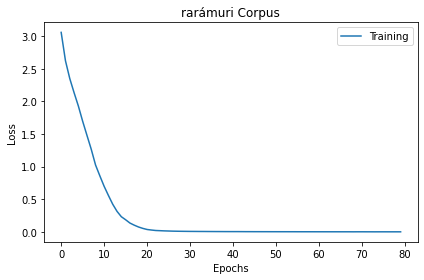

In [19]:
fig, ax = plt.subplots(1, 1, tight_layout = True, figsize = (6, 4))
plt.plot(loss_history)
plt.legend(['Training'])
plt.title(CORPUS_NAME + ' Corpus')
plt.xlabel('Epochs')
plt.ylabel('Loss')

if MAX_LENGTH == None:
    length = 'max'
else:
    length = str(MAX_LENGTH)

fig.savefig('./images/' + CORPUS_NAME + '_loss_len_' + length + '_rnn3.png', format = 'png')
#fig.savefig('/content/drive/MyDrive/Spanish-Tarahumara-Translator/images/' + CORPUS_NAME + '_loss_len_' + length + '_rnn3.png', format = 'png')

# Prediction Evaluation

In [20]:
def predict(input_text, encoder, decoder, input_max_len, output_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    
    # Tokenize the input sequence
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    
    # Pad the sentence
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    
    # Consider only unpadded part of the sequence
    input_mask = input_seq != 0
    
    # Generate encoder output
    en_outputs = encoder(tf.constant(input_seq))
    
    # Create the decoder input (<SOS> token)
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    
    # Set the decoder states to the encoder vector or encoder hidden state
    dec_state = en_outputs[1:]
    #dec_state = [en_outputs[3], en_outputs[4], en_outputs[1], en_outputs[2]]
    
    out_words = []
    while True:
        # Decode and get the output probabilities
        de_output, _, dec_state = decoder(de_input, en_outputs[0], input_mask, dec_state)
        
        # Select the word with the highest probability
        de_input = tf.argmax(de_output, -1)
        
        # Append the word to the predicted output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        
        # Finish when <EOS> token is found or the max length is reached
        if out_words[-1] == '<eos>' or len(out_words) >= output_max_len:
            break

    translation = ' '.join(out_words)
    return translation, out_words

## Evaluating Predictions with Training Set

In [21]:
predictions = corpus.train_set['Source'].apply(lambda x : predict(x, encoder, decoder, max_length_input, max_length_target, tok_enc, word2idx_outputs, idx2word_outputs)[0]).tolist()

In [22]:
pd.set_option('display.max_colwidth', 1000)
train_df = corpus.train_set
train_df['Predictions'] = predictions
train_df.head(5)

,Source,Target,Predictions
0,<SOS> ¿ dónde vive usted ? <EOS>,<SOS> ¿ comi bité mujé ? <EOS>,¿ comi bité comi comi bité mujé ¿ comi bité mujé comi bité mujé comi iyénari comi iyénari comi comi
1,<SOS> a lo que canta un pájaro . <EOS>,<SOS> mapu a'lí ta nalépua chulukí jíti . <EOS>,mapu riká aní <eos>
2,<SOS> está haciendo mucho frío . <EOS>,<SOS> hue ruluá . <EOS>,hue ruluá . <eos>
3,<SOS> tus abuelos maternos . <EOS>,<SOS> kému apalócha a'lí kému u'sú . <EOS>,kému apalócha a'lí kému u'sú kému u'sú . <eos>
4,<SOS> el tarahumar con el sonido de la piel despierta a sus padres <EOS>,<SOS> ralámuli wichí anéala kiti busurébi e'wénuala <EOS>,ralámuli wichí anéala kiti busurébi e'wénuala <eos>


### BLEU Scores Training Set

In [23]:
candidates_bleu = corpus.train_set['Source'].apply(lambda x : predict(x,encoder, decoder, max_length_input, max_length_target, tok_enc, word2idx_outputs, idx2word_outputs)[1]).tolist()

#### Translation and Target Preprocessing

In [24]:
# Prediction output preprocessing for calculating BLEU score
for i in range(len(candidates_bleu)):
    # Remove duplicate elements like commas
    candidates_bleu[i] = list(dict.fromkeys(candidates_bleu[i]))
    # Remove <EOS> token
    if '<eos>' in candidates_bleu[i]:
        candidates_bleu[i].remove('<eos>')
    # Remove special punctuation characters
    if '.' in candidates_bleu[i]:
        candidates_bleu[i].remove('.')
    if ',' in candidates_bleu[i]:
        candidates_bleu[i].remove(',')
    if '!' in candidates_bleu[i]:
        candidates_bleu[i].remove('!')
    if '¡' in candidates_bleu[i]:
        candidates_bleu[i].remove('¡')
    if '?' in candidates_bleu[i]:
        candidates_bleu[i].remove('?')
    if '¿' in candidates_bleu[i]:
        candidates_bleu[i].remove('¿')

# Target preprocessing for calculating BLEU score
references_bleu = train_df['Target'].to_list()

for i in range(len(references_bleu)):
    references_bleu[i] = references_bleu[i].split()
    # Remove duplicate elements like commas
    references_bleu[i] = list(dict.fromkeys(references_bleu[i]))
    # Remove <SOS> token
    references_bleu[i].remove('<SOS>')
    # Remove <EOS> token
    references_bleu[i].remove('<EOS>')
    # Remove special punctuation characters
    if '.' in references_bleu[i]:
        references_bleu[i].remove('.')
    if ',' in references_bleu[i]:
        references_bleu[i].remove(',')
    if '!' in references_bleu[i]:
        references_bleu[i].remove('!')
    if '¡' in references_bleu[i]:
        references_bleu[i].remove('¡')
    if '?' in references_bleu[i]:
        references_bleu[i].remove('?')
    if '¿' in references_bleu[i]:
        references_bleu[i].remove('¿')
        
references_bleu_train = list()
for i in range(len(references_bleu)):
    references_bleu_train.append(list())
    references_bleu_train[i].append(references_bleu[i])

* **Corpus BLEU Scores**

In [25]:
score = corpus_bleu(references_bleu_train, candidates_bleu, weights = (1,0,0,0))
print(f'Corpus BLEU-1 score: {score}')
score = corpus_bleu(references_bleu_train, candidates_bleu)
print(f'Corpus BLEU-4 score: {score}')

Corpus BLEU-1 score: 0.4531760826533838
Corpus BLEU-4 score: 0.2739660784704776


* **Sentence BLEU Scores**

In [26]:
sentence_bleu_scores = []
for i in range(len(references_bleu)):
    sentence_bleu_scores.append(sentence_bleu(references_bleu_train[i], candidates_bleu[i], weights = (1,0,0,0)))
train_df['BLEU-1'] = sentence_bleu_scores

sentence_bleu_scores = []
for i in range(len(references_bleu)):
    sentence_bleu_scores.append(sentence_bleu(references_bleu_train[i], candidates_bleu[i])) 
train_df['BLEU-4'] = sentence_bleu_scores
train_df.head(5)

C:\Users\eduar\anaconda3\envs\SMT\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\eduar\anaconda3\envs\SMT\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\eduar\anaconda3\envs\SMT\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

,Source,Target,Predictions,BLEU-1,BLEU-4
0,<SOS> ¿ dónde vive usted ? <EOS>,<SOS> ¿ comi bité mujé ? <EOS>,¿ comi bité comi comi bité mujé ¿ comi bité mujé comi bité mujé comi iyénari comi iyénari comi comi,0.750000,8.636169e-78
1,<SOS> a lo que canta un pájaro . <EOS>,<SOS> mapu a'lí ta nalépua chulukí jíti . <EOS>,mapu riká aní <eos>,0.122626,5.092529e-232
2,<SOS> está haciendo mucho frío . <EOS>,<SOS> hue ruluá . <EOS>,hue ruluá . <eos>,1.000000,1.491668e-154
3,<SOS> tus abuelos maternos . <EOS>,<SOS> kému apalócha a'lí kému u'sú . <EOS>,kému apalócha a'lí kému u'sú kému u'sú . <eos>,1.000000,1.000000e+00
4,<SOS> el tarahumar con el sonido de la piel despierta a sus padres <EOS>,<SOS> ralámuli wichí anéala kiti busurébi e'wénuala <EOS>,ralámuli wichí anéala kiti busurébi e'wénuala <eos>,1.000000,1.000000e+00


In [27]:
train_df.to_excel('./results/train_' + CORPUS_NAME + '_len_' + length + '_rnn3.xlsx')
#train_df.to_excel('/content/drive/MyDrive/Spanish-Tarahumara-Translator/results/train_' + CORPUS_NAME + '_len_' + length + '_rnn3.xlsx')

## Predictions with Validation Set

In [28]:
predictions = corpus.validation_set['Source'].apply(lambda x : predict(x, encoder, decoder, max_length_input, max_length_target, tok_enc, word2idx_outputs, idx2word_outputs)[0]).tolist()

In [29]:
validation_df = corpus.validation_set
validation_df['Predictions'] = predictions
validation_df.head(5)

,Source,Target,Predictions
0,<SOS> artículo 2o . <EOS>,<SOS> osirúa'mi 2 . <EOS>,cuira . <eos>
1,<SOS> ya haz nacer al maíz y a las demás plantas . <EOS>,<SOS> má ochébi suunú a'lí jalé chó reyawi . <EOS>,kéti retémali iwikáala jú . <eos>
2,<SOS> para que comience a nacer la hierba <EOS>,<SOS> mapuliká reyáwi chotáma a'wiyá <EOS>,mapuliká suunú chotáma a'wiyá . <eos>
3,<SOS> despiertan alegres al escuchar el eco . <EOS>,<SOS> népi busuré kaníla kipúu rampóli kebáala . <EOS>,mapu tibúla 'a 'níwi japu reká katewáma jéna rerécho . <eos>
4,<SOS> fue así como fueron creados los rarámuri y los chabochi <EOS>,<SOS> echiriká iwítali rarámuri alí chabochi <EOS>,"echiriká ra'icha aní rarámuri , mapú kú a'lá ra'icha aní rarámuri . <eos>"


### BLEU Score (Validation Set)

In [30]:
candidates_bleu = corpus.validation_set['Source'].apply(lambda x : predict(x, encoder, decoder, max_length_input, max_length_target, tok_enc, word2idx_outputs, idx2word_outputs)[1]).tolist()

#### Translation and Target Preprocessing

In [31]:
# Prediction output preprocessing for calculating BLEU score
for i in range(len(candidates_bleu)):
    # Remove duplicate elements like commas
    candidates_bleu[i] = list(dict.fromkeys(candidates_bleu[i]))
    # Remove <EOS> token
    if '<eos>' in candidates_bleu[i]:
        candidates_bleu[i].remove('<eos>')
    # Remove special punctuation characters
    if '.' in candidates_bleu[i]:
        candidates_bleu[i].remove('.')
    if ',' in candidates_bleu[i]:
        candidates_bleu[i].remove(',')
    if '!' in candidates_bleu[i]:
        candidates_bleu[i].remove('!')
    if '¡' in candidates_bleu[i]:
        candidates_bleu[i].remove('¡')
    if '?' in candidates_bleu[i]:
        candidates_bleu[i].remove('?')
    if '¿' in candidates_bleu[i]:
        candidates_bleu[i].remove('¿')
        
# Target preprocessing for calculating BLEU score
references_bleu = validation_df['Target'].to_list()

for i in range(len(references_bleu)):
    references_bleu[i] = references_bleu[i].split()
    # Remove duplicate elements like commas
    references_bleu[i] = list(dict.fromkeys(references_bleu[i]))
    # Remove <SOS> token
    references_bleu[i].remove('<SOS>')
    # Remove <EOS> token
    references_bleu[i].remove('<EOS>')
    # Remove special punctuation characters
    if '.' in references_bleu[i]:
        references_bleu[i].remove('.')
    if ',' in references_bleu[i]:
        references_bleu[i].remove(',')
    if '!' in references_bleu[i]:
        references_bleu[i].remove('!')
    if '¡' in references_bleu[i]:
        references_bleu[i].remove('¡')
    if '?' in references_bleu[i]:
        references_bleu[i].remove('?')
    if '¿' in references_bleu[i]:
        references_bleu[i].remove('¿')
        
references_bleu_validation = list()
for i in range(len(references_bleu)):
    references_bleu_validation.append(list())
    references_bleu_validation[i].append(references_bleu[i])

* **Corpus BLEU Scores**

In [32]:
score = corpus_bleu(references_bleu_validation, candidates_bleu, weights = (1,0,0,0))
print(f'Corpus BLEU-1 score: {score}')
score = corpus_bleu(references_bleu_validation, candidates_bleu)
print(f'Corpus BLEU-4 score: {score}')

Corpus BLEU-1 score: 0.06890561786967334
Corpus BLEU-4 score: 1.1912787306211627e-155


C:\Users\eduar\anaconda3\envs\SMT\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\eduar\anaconda3\envs\SMT\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


* **Sentence BLEU Scores**

In [33]:
sentence_bleu_scores = []
for i in range(len(references_bleu)):
    sentence_bleu_scores.append(sentence_bleu(references_bleu_validation[i], candidates_bleu[i], weights = (1,0,0,0)))
validation_df['BLEU-1'] = sentence_bleu_scores

sentence_bleu_scores = []
for i in range(len(references_bleu)):
    sentence_bleu_scores.append(sentence_bleu(references_bleu_validation[i], candidates_bleu[i]))
validation_df['BLEU-4'] = sentence_bleu_scores
validation_df.head(5)

C:\Users\eduar\anaconda3\envs\SMT\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\eduar\anaconda3\envs\SMT\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\eduar\anaconda3\envs\SMT\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

,Source,Target,Predictions,BLEU-1,BLEU-4
0,<SOS> artículo 2o . <EOS>,<SOS> osirúa'mi 2 . <EOS>,cuira . <eos>,0.000000,0.000000e+00
1,<SOS> ya haz nacer al maíz y a las demás plantas . <EOS>,<SOS> má ochébi suunú a'lí jalé chó reyawi . <EOS>,kéti retémali iwikáala jú . <eos>,0.000000,0.000000e+00
2,<SOS> para que comience a nacer la hierba <EOS>,<SOS> mapuliká reyáwi chotáma a'wiyá <EOS>,mapuliká suunú chotáma a'wiyá . <eos>,0.750000,1.054769e-154
3,<SOS> despiertan alegres al escuchar el eco . <EOS>,<SOS> népi busuré kaníla kipúu rampóli kebáala . <EOS>,mapu tibúla 'a 'níwi japu reká katewáma jéna rerécho . <eos>,0.000000,0.000000e+00
4,<SOS> fue así como fueron creados los rarámuri y los chabochi <EOS>,<SOS> echiriká iwítali rarámuri alí chabochi <EOS>,"echiriká ra'icha aní rarámuri , mapú kú a'lá ra'icha aní rarámuri . <eos>",0.285714,1.331960e-231


In [34]:
validation_df.to_excel('./results/val_' + CORPUS_NAME + '_len_' + length + '_rnn3.xlsx')
#validation_df.to_excel('/content/drive/MyDrive/Spanish-Tarahumara-Translator/results/val_' + CORPUS_NAME + '_len_' + length + '_rnn3.xlsx')

# References

<li><a href="https://aclanthology.org/D14-1179">Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation</a> (Cho et al., EMNLP 2014)</li>

<li><a href="https://arxiv.org/abs/1409.0473">Neural Machine Translation by Jointly Learning to Align and Translate</a> (Bahdanau et al., ICLR 2015)</li>

<li><a href="https://arxiv.org/abs/1809.06662">Bidirectional Attentional Encoder-Decoder Model and Bidirectional Beam Search for Abstractive Summarization</a> (Al-Sabahi et al., arXiv 2018)</li>

<li><a href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">TensorFlow Tutorial:  Neural Machine Translation with Attention</a> (GitHub Repository)</li>

<li><a href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb">TensorFlow Tutorial:  Text Generation with an RNN</a> (GitHub Repository)</li>

<li><a href="https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/networks_seq2seq_nmt.ipynb">TensorFlow Addons Networks:  Sequence-to-Sequence NMT with Attention Mechanism</a> (GitHub Repository)</li>

<li><a href="https://github.com/edumunozsala/NMT-encoder-decoder-Attention">NMT-encoder-decoder-Attention</a> (GitHub Repository)</li>

<li><a href="https://www.kaggle.com/code/rizdelhi/end-to-end-nlp-4-attention-and-transformer">end-to-end-nlp-4-attention-and-transformer</a> (Kaggle Notebook)</li>